# Predict Adverse Drug Reactions (ADRs) based on the Chemical Structure (CS) of the Drug using various statistical and Machine Learning techniques

In this project, our goal is to be able to predict drug Side Effects (SEs) based on the CS of the drugs.

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.bipartite.matrix import biadjacency_matrix
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

## Import Datasets

### Side-Effects Dataset

In [2]:
# Load Side Effects dataset
side_effects_df = pd.read_csv("Datasets/side-effect-and-drug_name_upper.tsv",sep = "\t")

In [3]:
drug_id = side_effects_df["drugbank_id"] 
drug_name = side_effects_df["drugbank_name"]
side_effects = side_effects_df["side_effect_name"]

In [4]:
# Create Bipartite Graph linking drugs to their associated Side Effects
edgelist = zip(drug_name, side_effects)
drug_side_effects_graph = nx.DiGraph()

drug_side_effects_graph.add_nodes_from(drug_name, bipartite=0)
drug_side_effects_graph.add_nodes_from(side_effects, bipartite=1)
drug_side_effects_graph.add_edges_from(edgelist)

In [5]:
# Get Unique Drug and Side Effect Nodes
drug_nodes = {n for n, d in drug_side_effects_graph.nodes(data=True) if d['bipartite'] == 0}
side_effect_nodes = {n for n, d in drug_side_effects_graph.nodes(data=True) if d['bipartite'] == 1}

# Transform into list and sort by name
drug_nodes = sorted(list(drug_nodes))
side_effect_nodes = sorted(list(side_effect_nodes))

In [6]:
# Get Biadjacency Matrix from Drug/Side-Effects Graph
drug_se_biadjacency_matrix = biadjacency_matrix(drug_side_effects_graph, row_order=drug_nodes ,column_order=side_effect_nodes)
drug_se_biadjacency_matrix = drug_se_biadjacency_matrix.A

/Users/sinead/PycharmProjects/FinalProject/venv/lib/python3.10/site-packages/scipy/sparse/_base.py:752: VisibleDeprecationWarning: Please use `.todense()` instead
  warn(np.VisibleDeprecationWarning(


In [7]:
drug_se_biadjacency_matrix.shape

(1020, 5599)

In [8]:
drug_se_biadjacency_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Chemical Structure/Fingerprint Dataset

In [9]:
# Load Drug Chemical Structure/Footprint Dataset
drug_fingerprint_df = pd.read_csv("Datasets/intersection_Fingerprint_mat.tsv",sep = "\t")

In [10]:
def FeaturePreprocess(df_all, drug_nodes):
    """ 
    Function to Preprocess the Drug Fingerprint Dataset.
    """
    # Only keep the drugs that are in df_all if they are in drug_nodes
    drug_nodes_df = np.intersect1d(df_all.index, drug_nodes)
    df = df_all.loc[drug_nodes_df]
    _, q = df.shape

    # Deal with drugs that are in drug_nodes but for which we don't have the chemical footprint
    # by giving them a array of 0s as the default chemical footprint.
    drug_nodes_diff = np.setdiff1d(drug_nodes, (df.index).tolist())
    n = len(drug_nodes_diff)
    df_diff = pd.DataFrame(np.zeros(n*q).reshape(n,q))
    df_diff.index = drug_nodes_diff
    df_diff.columns = df.columns

    print("We couldn't find the chemical footprint for n=" + str(n) + " molecules.")
    # Generate Final Fingerprint Matrix
    df_all = pd.concat([df, df_diff], axis = 0)
    featureMat = df_all.loc[drug_nodes]
    return np.array(featureMat)

In [11]:
fingerprint_matrix = FeaturePreprocess(drug_fingerprint_df, drug_nodes=drug_nodes)

We couldn't find the chemical footprint for n=243 molecules.


In [12]:
fingerprint_matrix.shape

(1020, 1024)

We can choose to keep the molecules for which we artificially filled in the chemical footprint, however we will exclude them in this analysis.

In [13]:
# Remove Molecules for which we don't have the Chemical Footprint
non_zero_idx = np.hstack(np.where(~(fingerprint_matrix.sum(1) == 0) & ~(fingerprint_matrix.sum(1) == 0)))
drug_se_biadjacency_matrix = drug_se_biadjacency_matrix[non_zero_idx]
fingerprint_matrix = fingerprint_matrix[non_zero_idx]

In [14]:
drug_se_biadjacency_matrix.shape

(777, 5599)

In [15]:
fingerprint_matrix.shape

(777, 1024)

### Train Test Split

In [16]:
# Split the dataframe into training set and test set
train_X, test_X = train_test_split(drug_se_biadjacency_matrix, test_size=0.2, random_state=42)
train_Y, test_Y = train_test_split(fingerprint_matrix, test_size=0.2, random_state=42)

## Computing different similarity matrices on the train set

In [17]:
def similarity_matrix_to_array(matrix):
    indices = np.triu_indices_from(matrix)
    return matrix[indices]

### Jaccard Similarity

In [18]:
jaccard_train_X = 1 - cdist(train_X, train_X, "jaccard")
jaccard_train_Y = 1 - cdist(train_Y, train_Y, "jaccard")

In [19]:
jaccard_train_X_array = similarity_matrix_to_array(jaccard_train_X)
jaccard_train_Y_array = similarity_matrix_to_array(jaccard_train_Y)

In [20]:
jaccard_train_X.shape

(621, 621)

In [21]:
jaccard_train_Y.shape

(621, 621)

### Tanimoto Similarity

In [22]:
tanimoto_train_X = 1 - cdist(train_X, train_X, "rogerstanimoto")
tanimoto_train_Y = 1 - cdist(train_Y, train_Y, "rogerstanimoto")

In [23]:
tanimoto_train_X_array = similarity_matrix_to_array(tanimoto_train_X)
tanimoto_train_Y_array = similarity_matrix_to_array(tanimoto_train_Y)

In [24]:
tanimoto_train_X.shape

(621, 621)

In [25]:
tanimoto_train_Y.shape

(621, 621)

### RBF Kernel

In [26]:
rbf_train_X = rbf_kernel(train_X) # Use default gamma value
rbf_train_Y = rbf_kernel(train_Y)

In [27]:
rbf_train_X_array = similarity_matrix_to_array(rbf_train_X)
rbf_train_Y_array = similarity_matrix_to_array(rbf_train_Y)

In [28]:
rbf_train_X.shape

(621, 621)

In [29]:
rbf_train_Y.shape

(621, 621)

## Finding polynomial relationships between drug similarity and side-effect similarity

Now that we have constructued different similarity matrices, let's see if we can find a direct relationship between drug similarity and side-effect similarity.

### Polynomial Fitting Function

In [30]:
def polynomial_function(x_matrix, y_matrix, degrees):
    # Convert matrices to arrays
    x_array = similarity_matrix_to_array(x_matrix)
    y_array = similarity_matrix_to_array(y_matrix)
    
    # Fit the polynomial using polyfit
    coefficients = np.polyfit(x_array, y_array, degrees)

    # Create a polynomial function using the coefficients
    polynomial = np.poly1d(coefficients)

    return polynomial

### Function to display the results

In [31]:
def show_results(X_similarity_array, Y_similarity_array, Y_similarity_array_pred):
    
    X_plot, Y_pred_plot = zip(*sorted(zip(X_similarity_array, Y_similarity_array_pred)))

    # Compute R-squared
    r_squared = r2_score(Y_similarity_array, Y_similarity_array_pred)
    print("R-squared:", r_squared)

    # Scatter plot
    plt.scatter(X_similarity_array, Y_similarity_array)

    # Set plot labels and title
    plt.xlabel('Chemical Footprint Similarity')
    plt.ylabel('Side-Effect Similarity')
    plt.title('Relationship Between Chemical Footprint and Side-Effect similarities')

    plt.plot(X_plot, Y_pred_plot, color='red')
    # Display the plot
    plt.show()


### Predict SE Jaccard Similarity Matrix Based on Chemical Footprint Similarity

#### One Degree Polynomial (Linear Regression)

In [32]:
jaccard_polynome_1d = polynomial_function(jaccard_train_X, jaccard_train_Y, 1)
Y_jaccard_polynome_1d_pred = jaccard_polynome_1d(jaccard_train_X_array)

R-squared: 0.13400209766033677


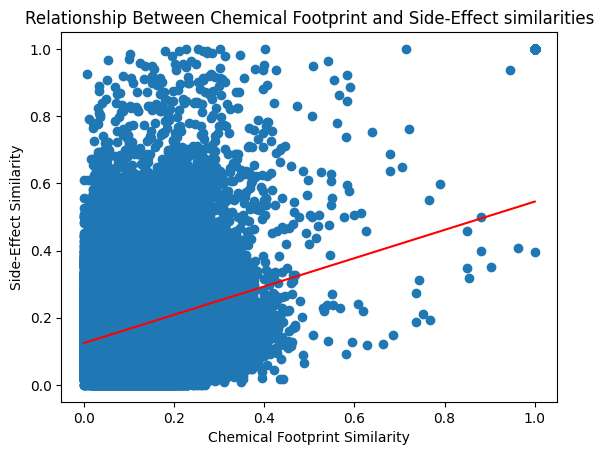

In [33]:
show_results(jaccard_train_X_array, jaccard_train_Y_array, Y_jaccard_polynome_1d_pred)

#### Two Degree Polynomial

In [34]:
jaccard_polynome_2d = polynomial_function(jaccard_train_X, jaccard_train_Y, 2)
Y_jaccard_polynome_2d_pred = jaccard_polynome_2d(jaccard_train_X_array)

R-squared: 0.23092586132543902


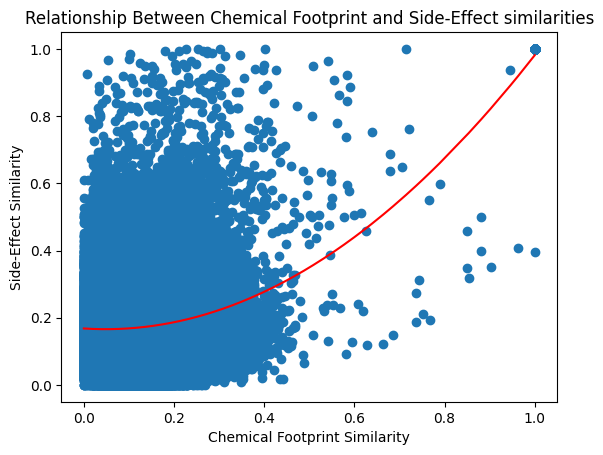

In [35]:
show_results(jaccard_train_X_array, jaccard_train_Y_array, Y_jaccard_polynome_2d_pred)

#### 10-Degree Polyimial

In [36]:
jaccard_polynome_10d = polynomial_function(jaccard_train_X, jaccard_train_Y, 10)
Y_jaccard_polynome_10d_pred = jaccard_polynome_10d(jaccard_train_X_array)

R-squared: 0.23708142774711805


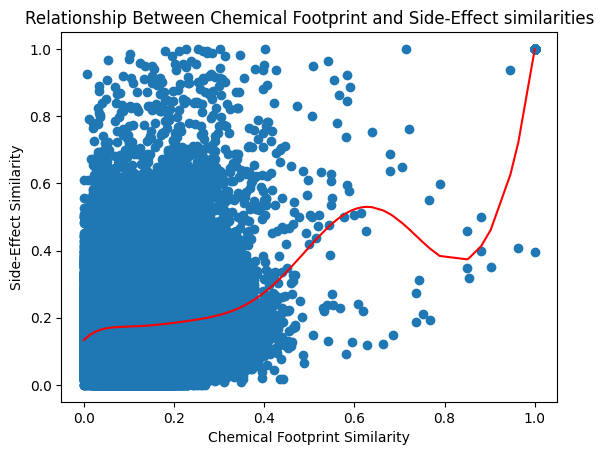

In [37]:
show_results(jaccard_train_X_array, jaccard_train_Y_array, Y_jaccard_polynome_10d_pred)

### Use Elastic Net Regression Model

In [38]:
jaccard_train_X_array_transpose = jaccard_train_X_array.reshape(-1, 1)

In [39]:
elastic_net_model = ElasticNet() # Initialise model
elastic_net_model.fit(jaccard_train_X_array_transpose, jaccard_train_Y_array)

ElasticNet()

R-squared: 0.0


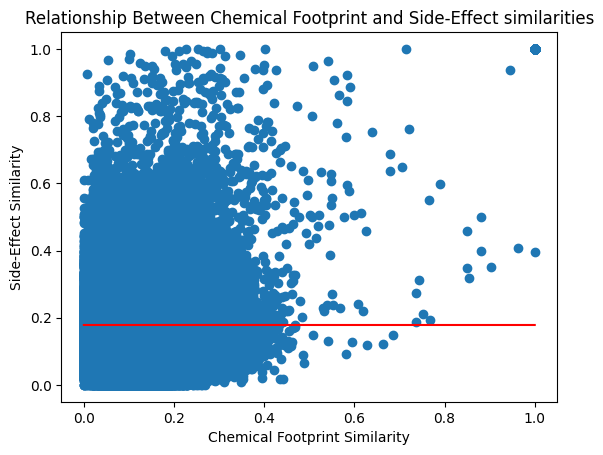

In [40]:
Y_elastic_net_model_pred = elastic_net_model.predict(jaccard_train_X_array_transpose)
show_results(jaccard_train_X_array, jaccard_train_Y_array, Y_elastic_net_model_pred)

### Use Random Forest Regression

In [41]:
rf_model = RandomForestRegressor() # Initialise model
rf_model.fit(jaccard_train_X_array_transpose, jaccard_train_Y_array)

RandomForestRegressor()

R-squared: 0.3436083700664284


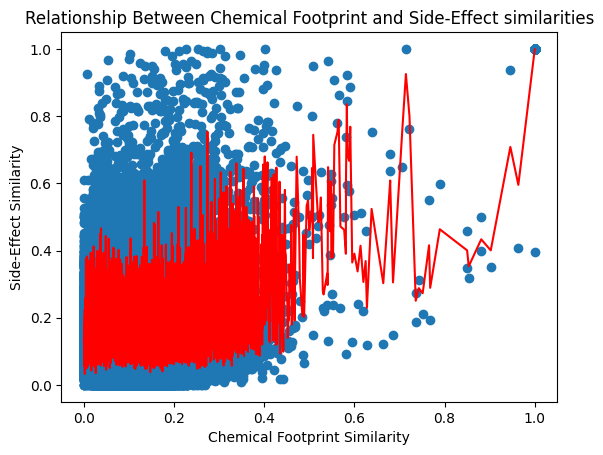

In [42]:
Y_rf_model_pred = rf_model.predict(jaccard_train_X_array_transpose)
show_results(jaccard_train_X_array, jaccard_train_Y_array, Y_rf_model_pred)

### Predict SE Tanimoto Similarity Matrix Based on Chemical Footprint Similarity

#### One Degree Polynomial (Linear Regression)

In [43]:
tanimoto_polynome_1d = polynomial_function(tanimoto_train_X, tanimoto_train_Y, 1)
Y_tanimoto_polynome_1d_pred = tanimoto_polynome_1d(tanimoto_train_X_array)

R-squared: 0.0031684518085740576


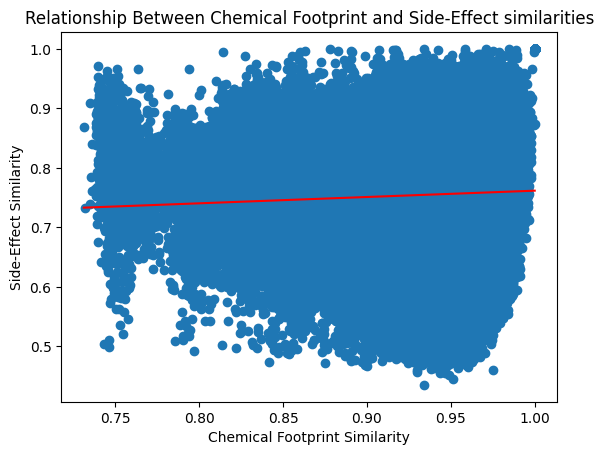

In [44]:
show_results(tanimoto_train_X_array, tanimoto_train_Y_array, Y_tanimoto_polynome_1d_pred)

#### Two Degree Polynomial

In [45]:
tanimoto_polynome_2d = polynomial_function(tanimoto_train_X, tanimoto_train_Y, 2)
Y_tanimoto_polynome_2d_pred = tanimoto_polynome_2d(tanimoto_train_X_array)

R-squared: 0.021584222736043657


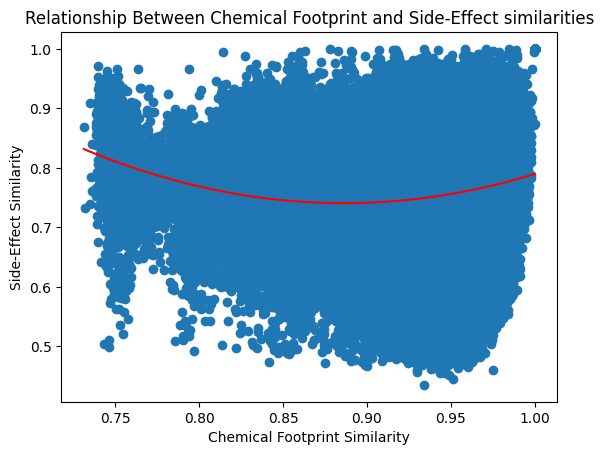

In [46]:
show_results(tanimoto_train_X_array, tanimoto_train_Y_array, Y_tanimoto_polynome_2d_pred)

#### 10-Degree Polyimial

In [47]:
tanimoto_polynome_10d = polynomial_function(tanimoto_train_X, tanimoto_train_Y, 10)
Y_tanimoto_polynome_10d_pred = tanimoto_polynome_10d(tanimoto_train_X_array)

/var/folders/5h/6l7jwyrd4p38nr9ym9d8rcjh0000gn/T/ipykernel_51170/2184403317.py:1: RankWarning: Polyfit may be poorly conditioned
  tanimoto_polynome_10d = polynomial_function(tanimoto_train_X, tanimoto_train_Y, 10)


R-squared: 0.04908715406912345


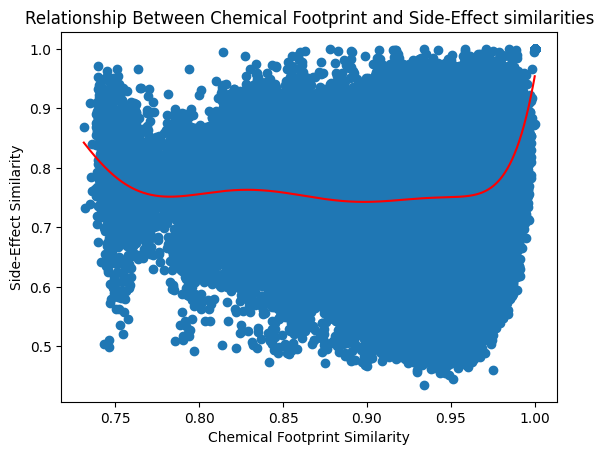

In [48]:
show_results(tanimoto_train_X_array, tanimoto_train_Y_array, Y_tanimoto_polynome_10d_pred)

### 

### Use Elastic Net Regression Model

In [49]:
tanimoto_train_X_array_transpose = tanimoto_train_X_array.reshape(-1, 1)

In [50]:
elastic_net_model = ElasticNet() # Initialise model
elastic_net_model.fit(tanimoto_train_X_array_transpose, tanimoto_train_Y_array)

ElasticNet()

R-squared: 0.0


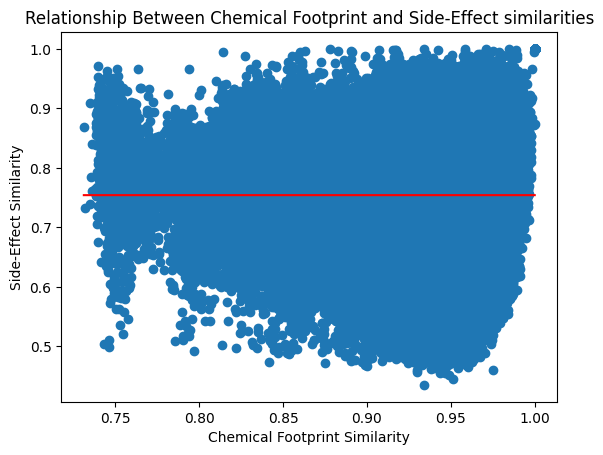

In [51]:
Y_elastic_net_model_pred = elastic_net_model.predict(tanimoto_train_X_array_transpose)
show_results(tanimoto_train_X_array, tanimoto_train_Y_array, Y_elastic_net_model_pred)

### Use Random Forest Regression

In [52]:
rf_model = RandomForestRegressor() # Initialise model
rf_model.fit(tanimoto_train_X_array_transpose, tanimoto_train_Y_array)

RandomForestRegressor()

R-squared: 0.060590561069856164


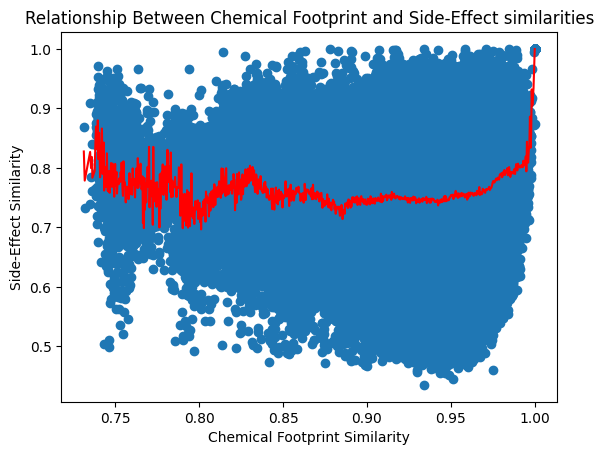

In [53]:
Y_rf_model_pred = rf_model.predict(tanimoto_train_X_array_transpose)
show_results(tanimoto_train_X_array, tanimoto_train_Y_array, Y_rf_model_pred)

### Predict SE Tanimoto Similarity Matrix Based on Chemical Footprint Similarity

#### One Degree Polynomial (Linear Regression)

In [54]:
rbf_polynome_1d = polynomial_function(rbf_train_X, rbf_train_Y, 1)
Y_rbf_polynome_1d_pred = rbf_polynome_1d(rbf_train_X_array)

R-squared: 0.0026778061697033673


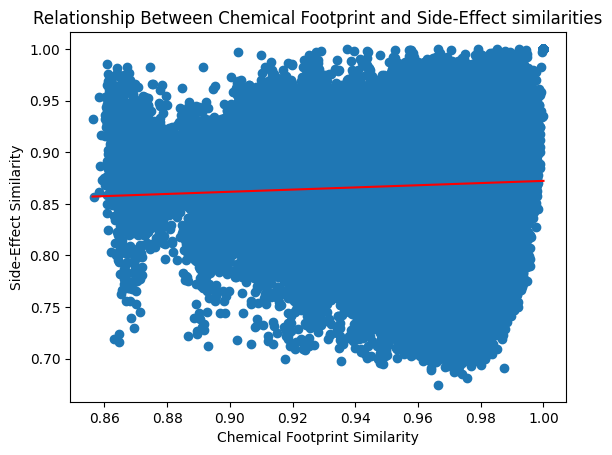

In [55]:
show_results(rbf_train_X_array, rbf_train_Y_array, Y_rbf_polynome_1d_pred)

#### Two Degree Polynomial

In [56]:
rbf_polynome_2d = polynomial_function(rbf_train_X, rbf_train_Y, 2)
Y_rbf_polynome_2d_pred = rbf_polynome_2d(rbf_train_X_array)

R-squared: 0.019764620723726867


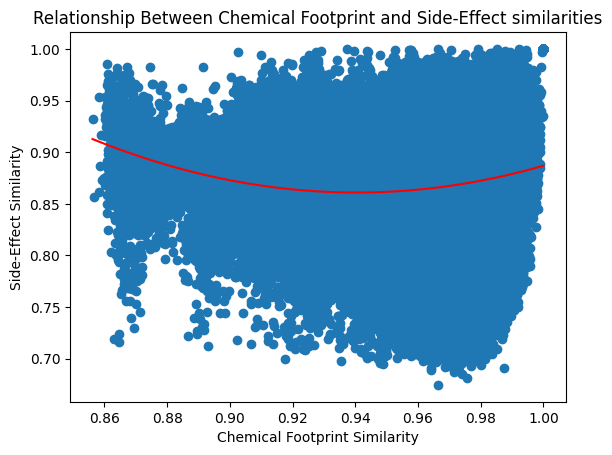

In [57]:
show_results(rbf_train_X_array, rbf_train_Y_array, Y_rbf_polynome_2d_pred)

#### 10-Degree Polyimial

In [58]:
rbf_polynome_10d = polynomial_function(rbf_train_X, rbf_train_Y, 10)
Y_rbf_polynome_10d_pred = rbf_polynome_10d(rbf_train_X_array)

/var/folders/5h/6l7jwyrd4p38nr9ym9d8rcjh0000gn/T/ipykernel_51170/1446837172.py:1: RankWarning: Polyfit may be poorly conditioned
  rbf_polynome_10d = polynomial_function(rbf_train_X, rbf_train_Y, 10)


R-squared: 0.04475584668288102


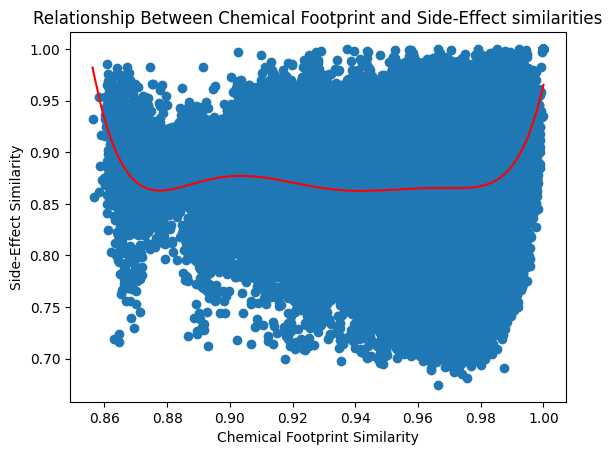

In [59]:
show_results(rbf_train_X_array, rbf_train_Y_array, Y_rbf_polynome_10d_pred)

### Use Elastic Net Regression Model

In [60]:
rbf_train_X_array_transpose = rbf_train_X_array.reshape(-1, 1)

In [61]:
elastic_net_model = ElasticNet() # Initialise model
elastic_net_model.fit(rbf_train_X_array_transpose, rbf_train_Y_array)

ElasticNet()

R-squared: 0.0


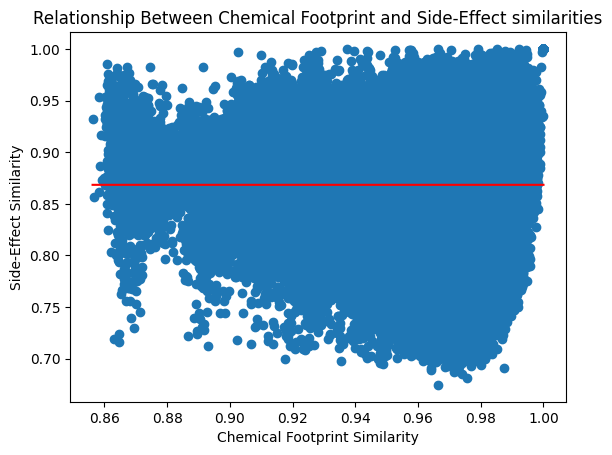

In [62]:
Y_elastic_net_model_pred = elastic_net_model.predict(rbf_train_X_array_transpose)
show_results(rbf_train_X_array, rbf_train_Y_array, Y_elastic_net_model_pred)

### Use Random Forest Regression

In [63]:
rf_model = RandomForestRegressor() # Initialise model
rf_model.fit(rbf_train_X_array_transpose, rbf_train_Y_array)

RandomForestRegressor()

R-squared: -0.06381744436933978


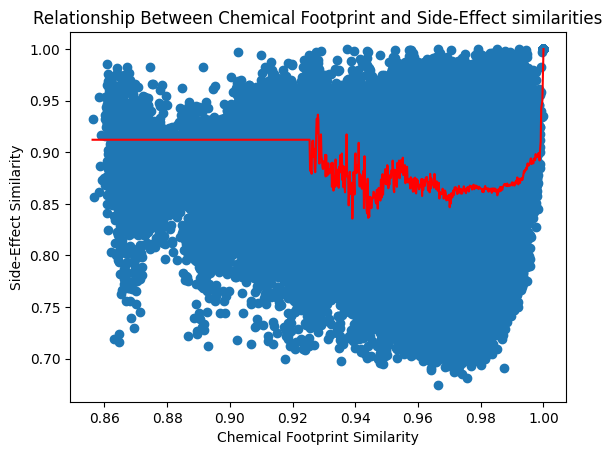

In [64]:
Y_rf_model_pred = rf_model.predict(tanimoto_train_X_array_transpose)
show_results(rbf_train_X_array, rbf_train_Y_array, Y_rf_model_pred)